# Projeto de Redes Neurais Profundas – Treinamento
Este notebook realiza o treinamento da rede binária Wide ResNet com visualização das curvas de aprendizado.

In [43]:
# Instalação de dependências
!pip install albumentations --quiet

In [44]:
# Clonar o repositório com o código do projeto
!git clone --branch entrega-2 https://github.com/ICEI-PUC-Minas-PPL-CDIA/projeto-5-redes-profundas-projeto-v-produtos-industriais.git
%cd projeto-5-redes-profundas-projeto-v-produtos-industriais
import sys
sys.path.append("/content/projeto-5-redes-profundas-projeto-v-produtos-industriais")


Cloning into 'projeto-5-redes-profundas-projeto-v-produtos-industriais'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 292 (delta 16), reused 28 (delta 12), pack-reused 241 (from 1)
Receiving objects: 100% (292/292), 10.09 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/projeto-5-redes-profundas-projeto-v-produtos-industriais/projeto-5-redes-profundas-projeto-v-produtos-industriais/projeto-5-redes-profundas-projeto-v-produtos-industriais/projeto-5-redes-profundas-projeto-v-produtos-industriais


In [45]:
# Montar o Google Drive para acessar os dados
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports principais

Nesta célula são importadas as bibliotecas fundamentais para o treinamento da rede neural:

- `torch`, `nn` e `optim`: componentes do PyTorch usados para definir o modelo, a função de perda e o otimizador.
- `matplotlib.pyplot`: utilizado para gerar gráficos como as curvas de loss e acurácia ao longo do treinamento.
- `WRN_McDonnell`: a arquitetura da rede neural binária baseada na Wide Residual Network modificada, implementada de acordo com o artigo **"Training Wide Residual Networks for Deployment Using a Single Bit for Each Weight"** (McDonnell, ICLR 2018).


In [46]:
# Imports principais
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from src.bynary_wide_resnet.wrn_mcdonnell import WRN_McDonnell


## Preparação dos DataLoaders

Esta célula define a função `get_dataloaders()`, responsável por preparar os conjuntos de dados de treino e teste. Ela executa as seguintes etapas:

1. **Carregamento das imagens e rótulos**
   - A função `load_image_paths_and_labels()` percorre os diretórios da base de dados e associa cada imagem a uma classe.

2. **Divisão entre treino e teste**
   - A divisão estratificada é feita por `split_dataset()`, mantendo a proporção de cada classe nos dois conjuntos.

3. **Aplicação de transformações**
   - No modo `train`, são aplicadas transformações como rotação, brilho e flip para aumentar a robustez do modelo.
   - No modo `test`, apenas redimensionamento e normalização são aplicados.

4. **Criação dos objetos Dataset e DataLoader**
   - `CableDataset` representa um conjunto de imagens com seus rótulos.
   - `DataLoader` empacota os dados em lotes (`batch_size`) e gerencia a iteração durante o treino e teste.

> Essa função retorna dois objetos: `train_loader` e `test_loader`, prontos para serem usados no treinamento e validação do modelo.


In [47]:
from src.utils.load_data import load_image_paths_and_labels
from src.utils.split_data import split_dataset
from src.utils.transform import AlbumentationsTransform
from src.utils.dataset import CableDataset
from torch.utils.data import DataLoader

def get_dataloaders(batch_size=8, test_size=0.2, num_workers=2):
    # Carregar caminhos e rótulos
    root_dir = '/content/drive/MyDrive/Projeto-V/data/balanced cable'
    image_paths, labels, class_to_idx = load_image_paths_and_labels(root_dir)

    # Dividir em treino e teste
    (train_paths, train_labels), (test_paths, test_labels) = split_dataset(
        image_paths,
        labels,
        test_size=test_size
    )

    # Criar datasets
    train_dataset = CableDataset(
        train_paths,
        train_labels,
        transform=AlbumentationsTransform(
            mode="train"
        )
    )
    test_dataset = CableDataset(
        test_paths,
        test_labels,
        transform=AlbumentationsTransform(
            mode="test"
        )
    )

    # Criar dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader


### Carregamento dos Dados e Visualização de um Batch

Nesta célula, carregamos os dados com a função `get_dataloaders()` e visualizamos um batch de imagens para verificar se o carregamento e a associação de rótulos foram feitos corretamente.



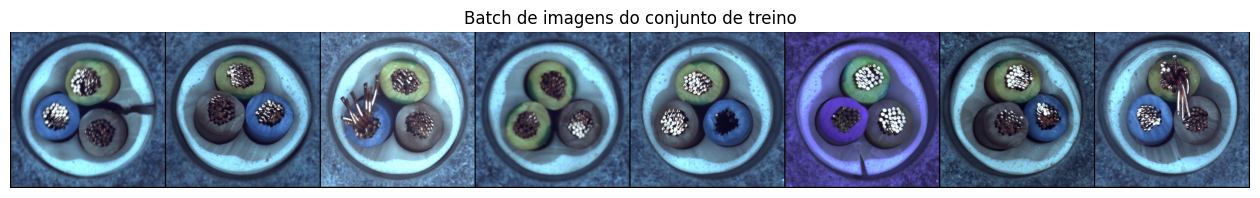

In [48]:
train_loader, test_loader = get_dataloaders()

def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(16, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Batch de imagens do conjunto de treino")
    plt.axis('off')
    plt.show()

show_batch(train_loader)


In [49]:
#Verificando Distribuição das classes
from collections import Counter

# Reextração dos rótulos dos datasets
train_labels = [label for _, label in train_loader.dataset]
test_labels = [label for _, label in test_loader.dataset]

print("Distribuição das classes no TREINO:")
print(Counter(train_labels))

print("\nDistribuição das classes no TESTE:")
print(Counter(test_labels))


Distribuição das classes no TREINO:
Counter({3: 11, 5: 10, 6: 10, 0: 10, 2: 9, 1: 9, 8: 8, 4: 8, 7: 8})

Distribuição das classes no TESTE:
Counter({1: 3, 3: 3, 0: 3, 7: 2, 8: 2, 5: 2, 4: 2, 2: 2, 6: 2})


## Configurações de treinamento

Nesta célula são definidos os principais parâmetros que controlam o treinamento da rede, assim como o dispositivo (CPU ou GPU) que será utilizado.

- `DEVICE`: Define se o modelo será treinado em GPU (`cuda`) ou CPU, dependendo da disponibilidade. O uso de GPU acelera significativamente o treinamento, especialmente em modelos com grande volume de dados ou profundidade.
  
- `NUM_CLASSES`: Define o número de classes presentes no conjunto de dados. Este valor deve ser igual ao número de categorias diferentes que o modelo deve aprender a classificar. No caso atual, estamos utilizando **9 classes**.

- `EPOCHS`: Número de épocas (passagens completas pelo conjunto de treinamento). Um valor mais alto permite que o modelo aprenda melhor, mas também aumenta o tempo de execução. É necessário monitorar o desempenho para evitar overfitting.

- `LR` (Learning Rate): Taxa de aprendizado do otimizador. Este hiperparâmetro controla o tamanho dos ajustes feitos nos pesos da rede durante o treinamento. Valores muito altos podem causar instabilidade, enquanto valores muito baixos podem tornar o aprendizado lento.

- `BATCH_SIZE`: Quantidade de amostras utilizadas em cada iteração do treinamento. Um valor maior aumenta o uso de memória, mas pode melhorar a estabilidade do gradiente. Neste caso, usamos 64 imagens por batch.

Essas configurações são utilizadas ao longo do notebook para inicializar o modelo, definir o otimizador e estruturar o loop de treinamento.


In [50]:
# Configurações de treino
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 9
EPOCHS = 20
LR = 0.01
BATCH_SIZE = 32

## Inicialização do modelo, função de perda, otimizador e dataloaders

Esta célula prepara todos os componentes necessários para iniciar o processo de treinamento da rede neural.




In [51]:
# Inicializar modelo, dataloaders e otimizador
model = WRN_McDonnell(
    depth=22,
    width=4,
    num_classes=NUM_CLASSES,
    binarize=True
    ).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=LR,
    momentum=0.9,
    weight_decay=5e-4
    )

train_loader, test_loader= get_dataloaders(batch_size=BATCH_SIZE)

## Funções auxiliares para treino e validação

Estas funções encapsulam a lógica principal das fases de **treinamento** e **validação** da rede, permitindo uma estrutura de código mais clara, reutilizável e modular.

### `train_one_epoch`

Executa **uma época completa de treinamento** sobre os dados de treino.  
Passo a passo do que ocorre dentro da função:
1. `model.train()`: Coloca o modelo em modo de treinamento, ativando camadas como dropout e batch normalization.
2. Para cada batch do `dataloader`:
   - Move as imagens (`x`) e os rótulos (`y`) para o dispositivo de execução (GPU/CPU).
   - Zera os gradientes acumulados com `optimizer.zero_grad()`.
   - Faz a inferência com `model(x)` e calcula a perda com a `criterion`.
   - Executa `loss.backward()` para computar os gradientes via backpropagation.
   - Atualiza os pesos com `optimizer.step()`.
   - Acumula a perda total e o número de acertos.
3. Retorna:
   - **Perda média** da época (`total_loss / len(dataloader)`).
   - **Acurácia (%)**: percentual de previsões corretas.

### `evaluate`

Realiza a **avaliação do modelo** sobre o conjunto de validação/teste, **sem alterar os pesos**:
1. `model.eval()`: Coloca o modelo em modo de avaliação, desativando dropout e congelando batch normalization.
2. Envolve a execução em `with torch.no_grad()` para evitar o cálculo e o armazenamento de gradientes, economizando memória.
3. Para cada batch:
   - Move os dados para o dispositivo.
   - Faz a inferência e calcula a perda.
   - Acumula os acertos e o total de amostras.
4. Retorna:
   - **Perda média** da avaliação.
   - **Acurácia (%)** da predição sobre o conjunto de validação/teste.

---

Essas duas funções serão usadas no loop de épocas para medir o desempenho do modelo em cada etapa do treinamento.


In [52]:
# Funções auxiliares para treino e validação
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(dataloader), 100 * correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(dataloader), 100 * correct / total

## Loop de treinamento

Nesta etapa, o modelo é treinado por várias épocas (definidas anteriormente pela variável `EPOCHS`).  
Durante cada época, executamos uma rodada de treino e uma de validação, registrando as métricas principais para análise posterior.

### Variáveis de acompanhamento

São criadas quatro listas para armazenar o histórico de métricas ao longo das épocas:
- `train_losses`: perdas (loss) no conjunto de treino por época.
- `test_losses`: perdas no conjunto de validação por época.
- `train_accs`: acurácias no conjunto de treino por época.
- `test_accs`: acurácias no conjunto de validação por época.

### Laço de épocas

Para cada época:
1. **Treinamento**: `train_one_epoch(...)`
   - Calcula a perda e acurácia no conjunto de treino.
   - Atualiza os pesos da rede.
2. **Validação**: `evaluate(...)`
   - Mede a performance da rede sobre dados **não vistos** (sem alterar pesos).
3. Os resultados são armazenados nas listas para análise posterior.
4. Um `print` resume os resultados da época, com:
   - `Loss={tloss:.4f}/{vloss:.4f}`: perda de treino e validação.
   - `Acc={tacc:.2f}%/{vacc:.2f}%`: acurácia de treino e validação.




In [53]:
# Loop de treino
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    tloss, tacc = train_one_epoch(model, train_loader, criterion, optimizer)
    vloss, vacc = evaluate(model, test_loader, criterion)
    train_losses.append(tloss)
    test_losses.append(vloss)
    train_accs.append(tacc)
    test_accs.append(vacc)
    print(f"Época {epoch+1}: Loss={tloss:.4f}/{vloss:.4f}, Acc={tacc:.2f}%/{vacc:.2f}%")

Época 1: Loss=2.2168/2.3294, Acc=9.64%/9.52%
Época 2: Loss=2.1239/2.2034, Acc=24.10%/9.52%
Época 3: Loss=2.0977/2.1551, Acc=36.14%/9.52%
Época 4: Loss=2.1098/2.1777, Acc=36.14%/9.52%
Época 5: Loss=2.0679/2.1765, Acc=33.73%/9.52%
Época 6: Loss=2.0552/2.1492, Acc=42.17%/9.52%
Época 7: Loss=2.0023/2.1454, Acc=40.96%/9.52%
Época 8: Loss=1.9868/2.1282, Acc=57.83%/9.52%
Época 9: Loss=1.9803/2.0687, Acc=54.22%/19.05%
Época 10: Loss=1.9596/2.0093, Acc=60.24%/38.10%
Época 11: Loss=1.9680/2.0116, Acc=53.01%/28.57%
Época 12: Loss=1.9386/2.0343, Acc=51.81%/19.05%
Época 13: Loss=1.9114/2.0081, Acc=54.22%/47.62%
Época 14: Loss=1.9031/1.9764, Acc=55.42%/42.86%
Época 15: Loss=1.8978/1.9796, Acc=53.01%/47.62%
Época 16: Loss=1.8686/1.9555, Acc=56.63%/38.10%
Época 17: Loss=1.8414/1.9782, Acc=59.04%/28.57%
Época 18: Loss=1.8476/1.9221, Acc=56.63%/28.57%
Época 19: Loss=1.8170/1.9343, Acc=61.45%/33.33%
Época 20: Loss=1.8309/2.0146, Acc=61.45%/19.05%


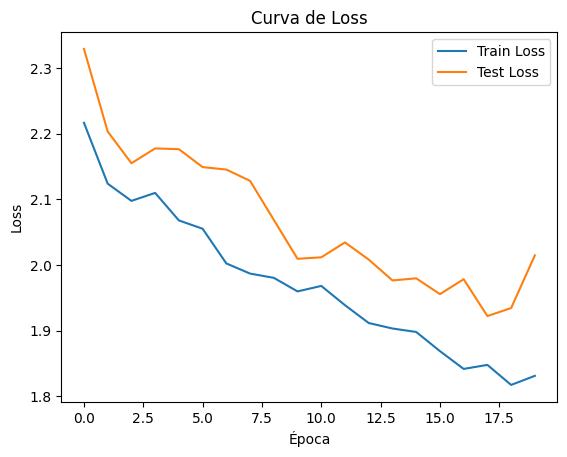

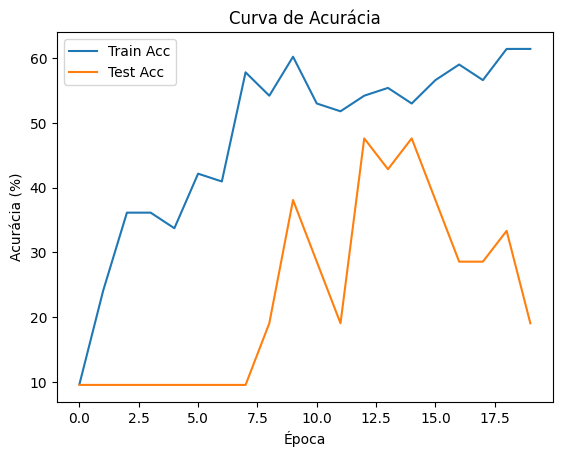

In [54]:
# Visualização das curvas
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Curva de Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title("Curva de Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.legend()
plt.show()

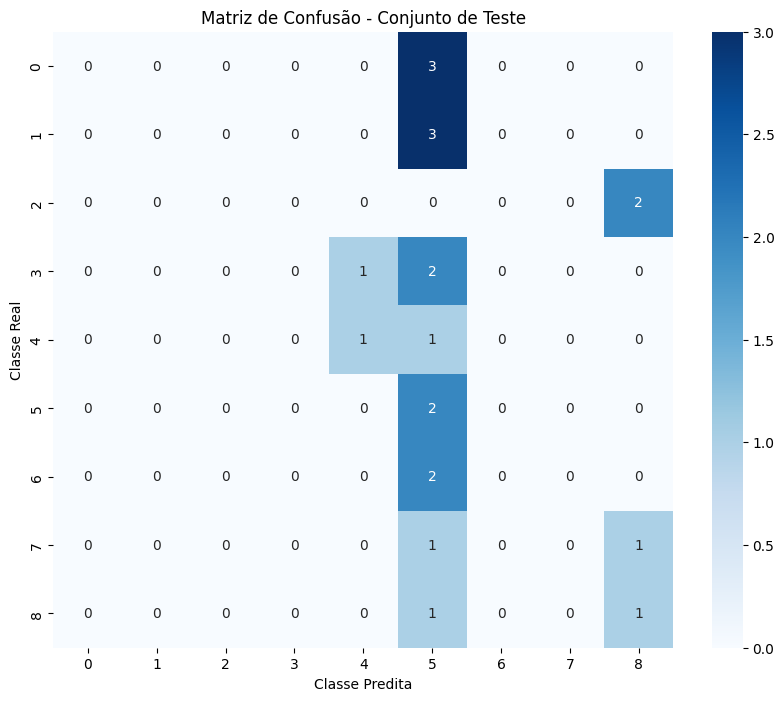

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Avaliação final e predição de todas as imagens de teste
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Geração da matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusão - Conjunto de Teste")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()


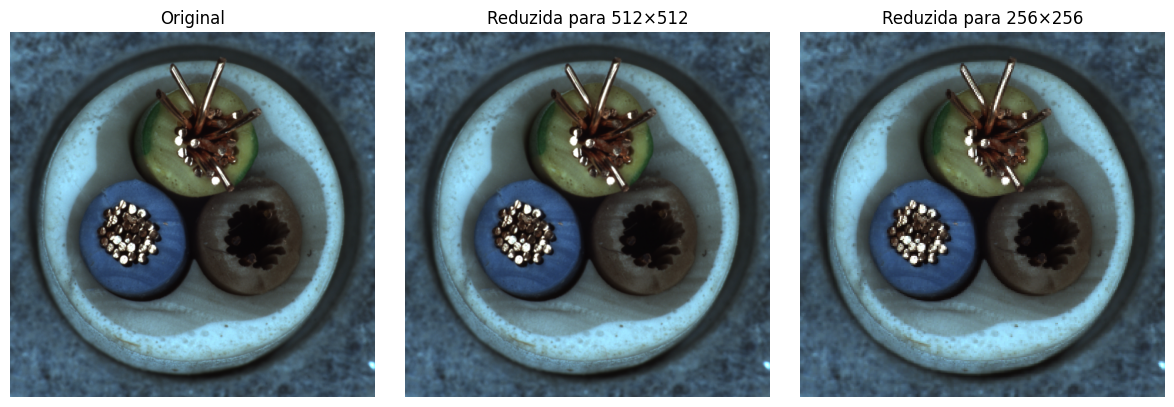

In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

original_path = train_loader.dataset.image_paths[0]  # Pega a primeira imagem
image = Image.open(original_path).convert("RGB")

# Redimensiona para 256 e 512 com albumentations
transform256 = A.Resize(256, 256)
transform512 = A.Resize(512, 512)

img_256 = transform256(image=np.array(image))['image']
img_512 = transform512(image=np.array(image))['image']

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_512)
plt.title("Reduzida para 512×512")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_256)
plt.title("Reduzida para 256×256")
plt.axis("off")

plt.tight_layout()
plt.show()
